In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.style.use('fivethirtyeight')

# Problem 11.7 - Fogler - 5ed

The gas-phase reversible reaction

\begin{equation}
A \leftrightarrows B
\end{equation}

is carried out under high pressure in a packed-bed reactor with pressure drop. The feed consists of both inerts **I** and Species **A** with the ratio of inerts to the species A being 2 to 1. The entering molar flow rate of A is 5 mol/min at a temperature of 300 K and a concentration of 2 mol/dm3. **Work this problem in terms of volume.**
 
_Additional information:_

Parameter | Value | Parameter | Value
- | - | - | -
Fao | 5.0 mol/min | T0 | 300 K 
CA0 | 2 mol/dm$^3$ | Ti | 300 K
CI | 2 CA0 | k (300 K) |  0.1 1/min
CpI |18 cal/mol/K | Ua | 150 cal/dm3/min/K
CPA |160 cal/mol/K | $T_{ao}$ | 300 K
E | 10,000 cal/mol | V | 40 dm$^3$
$\Delta H$Rx | −20,000 cal/mol | $\alpha \rho_b$ | 0.02 1/dm$^3$
KC(300 K) | 1,000 | | 
CPB | 160 cal/mol/K | m_c | 50 mol/min
$\rho_B$ |1.2 kg/dm3 | Cpcool | 20 cal/mol/K


1. **Adiabatic Operation**. Plot X, Xe, p, T, and the rate of disappearance as a function of V up to V = 40 dm3. Explain why the curves look the way they do.
2. Vary the ratio of inerts to A (0 ≤ ΘI ≤ 10) and the entering temperature, and describe what you find.
3. Plot the heat that must be removed along the reactor (Q ̇ vs. V) to maintain isothermal operation. Part (c) is “C” level of difficulty.

In [3]:
# Data

Fa0 = 5.0           # initial molar flowrate A, mol/min
CA0 = 2             # initial concentration A, mol/dm$^3$ 
CI0 = 2*CA0         # initial concentration Inert, mol/dm3

T0 = 300            # initial reactor temperature, K 
Ti = 300            # inlet inert temperature, K
Ta0 = 300           # inlet coolant temperature, K 

CPA = 160           # cal/mol/K 
CPB = 160           # cal/mol/K 
CPI = 18            # cal/mol/K 
Cpcool = 20         # cal/mol/K
Ua = 150            # cal/dm3/min/K

k_300 = 0.1         # 1/min
KC_300 = 1000 
Ea = 10000          # cal/mol 
DHRx = -20000       # cal/mol 

V = 40              # dm$^3$

rho_B = 1.2         # kg/dm3 
alpha_rho_b = 0.02  # 1/dm$^3$

m_c = 50             # mol/min

Rgas = 1.987

# Part (a) Adiabatic Operation

In [4]:
def system(v, Y, parameters):
    
    x, t, p, ta = Y
    phii, to, if_adiabatic = parameters
    
    
    v = Vo * (1/p) * (t/to)
    fa = Fa0 * (1 - x)
    fb = Fa0 * x
    fi = Fi0
    
    ft = fa + fb + fi
    
    ca = fa / v
    cb = fb / v
    
    # Kinetic parameters
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/300))
    kc = KC_300 * np.exp(-DHRx/Rgas * (1/t - 1/300))
    ra = -k * (ca - cb / kc)
    
    if if_adiabatic:
        Ua = 0
    
    # Energy balance terms
    qg = ra * DHRx
    qr = Ua * (t - ta)
    
    # System of ODEs
    dx_dv = -ra/Fa0
    dt_dv = (qg - qr) / (Fa0 * (CPA + phii * CPI + DCp * x))
    dp_dv = -alpha_rho_b / (2 * p) * (t/to) * (ft/Ft0)
    dta_dv = qr / (m_c * Cpcool)
    
    return [dx_dv, dt_dv, dp_dv, dta_dv]

In [5]:
DCp = CPB - CPA - CPI
Vo = Fa0 / CA0           # inlet volumetric flow rate, dm3/min
Fi0 = Vo * CI0

Ft0 = Fa0 + Fi0

Ct0 = Ft0 / Vo
P0 = 8.314 * 10**3 * T0/Ct0

In [6]:
iCs = [0, T0, 1, Ta0]

Parameters = [Fi0/Fa0, T0, True]

fun = lambda v, Y: system(v, Y, Parameters)

vspan = [0, V]  #  independent variable range

solODE = solve_ivp(fun, vspan, iCs, t_eval=np.linspace(0, V))

In [7]:
Vreactor = solODE.t
Xa = solODE.y[0]
Temp_reactor = solODE.y[1]
p = solODE.y[2]
Temp_coolant = solODE.y[3]

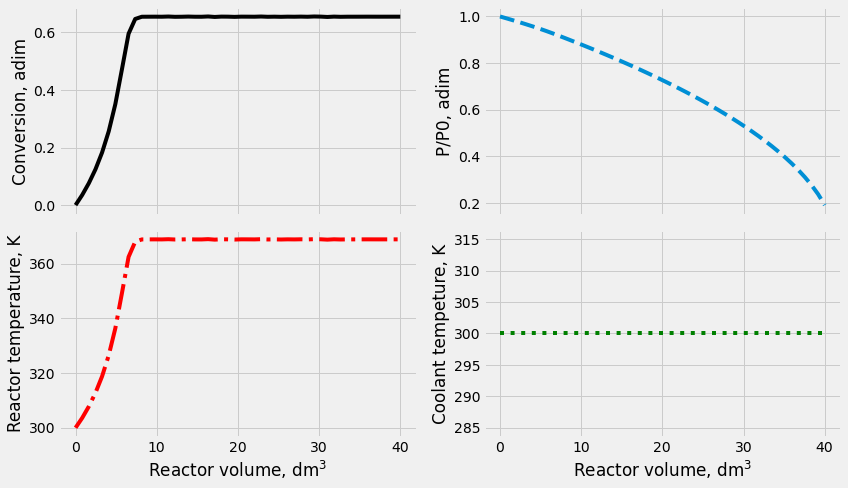

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

ax1.plot(Vreactor, Xa, color='black')
ax1.set_ylabel('Conversion, adim')

ax2.plot(Vreactor, p, ls='--')
ax2.set_ylabel('P/P0, adim')

ax3.plot(Vreactor, Temp_reactor, color='red', ls='-.')
ax3.set_xlabel(r'Reactor volume, dm$^3$')
ax3.set_ylabel('Reactor temperature, K')

ax4.plot(Vreactor, Temp_coolant, color='green', ls=':')
ax4.set_xlabel(r'Reactor volume, dm$^3$')
ax4.set_ylabel('Coolant tempeture, K')

plt.tight_layout()
plt.show()

In [9]:
Kc = KC_300 * np.exp(-DHRx/Rgas * (1/Temp_reactor - 1/300))
Xe = Kc / (1 + Kc)

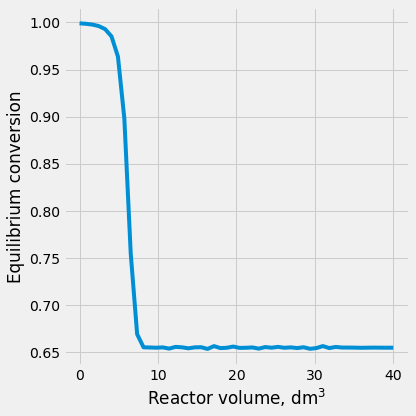

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(Vreactor, Xe)
ax.set_xlabel(r'Reactor volume, dm$^3$')
ax.set_ylabel('Equilibrium conversion')


plt.tight_layout()
plt.show()